## Leaky integrated firing neuron model  
## Few feautures :
### Spatial network, no memory term but exponential dacy of cumulative dose

This is a minor change of the Dodds and Watts model  
Adaptive rewiring has still not been implemented

In [363]:
#importing the required libraries

import networkx as nx #network library to generate inital networks and perform various network operations
from matplotlib import animation
import matplotlib.pyplot as plt #for plotting
import numpy as np #for using arrays and vectorising the code wherever possible
import scipy
import random
import cProfile #for timing the loops
from numba import jit #numba precomplier to make the code faster
import pandas as pd
import time
%matplotlib notebook

# Variables used in the simulation

In [364]:
N = 500
gamma = 5 #decay of cumulative dose per unit time (second)
T = 100 #total number of seconds
dt = 0.1 #seconds
'''number of simulation steps is T/dt'''
d_star = 12
p = 0.3 #proability of dose transfer per unit time (second)....??
# p = p*dt #probaility of dose transfer per unit simulation step...??
r = 1
rho = 1
circ_rad = 100
dose_quantity = 1
D_ini = 15

# nn = 2
# p_rew = 0.5

# Creating the network. 
### The network outputs coordinates, distance matrix, edge_list and adjacency matrix

In [365]:
# #creating the static Watts-Strogatz network
# def static_network(N,nn,p_rew) :
#     G = nx.watts_strogatz_graph(N,nn,p_rew) #no rewiring for now

#     #obtaining the edges via the adjancency matrix
#     adj_mat = nx.adjacency_matrix(G,nodelist=range(N))
#     adj_mat = scipy.sparse.csr_matrix.toarray(adj_mat)
    
#     return G, adj_mat

In [366]:
'''
obtains the number of nodes N
generates N points
calculates euclidean distance between each pair of points
returns the coordinates of the points and the distance matrix which is N*N
'''
def calc_dist(N) :
    coords = []
    for counter in range(N) :
        coords.append((N*np.random.random(),N*np.random.random()))

    dist_mat = scipy.spatial.distance.cdist(coords,coords)
    return dist_mat,coords

In [367]:
'''network = connect to points withing a circle of radius'''
#creates a link between points/nodes which satisfies the conditions of the network
def coupling(dist_mat) :
    edge_list = []
    edge_mask = (dist_mat<circ_rad) & (dist_mat>0)
    edge_list.extend(np.ndarray.tolist(np.transpose(np.where(edge_mask))))
#     print(type(np.ndarray.tolist(np.transpose(np.where(edge_mask)))))
    return edge_list

In [368]:
'''coordinates, distance matrix, edge_lsit and the adjacency matrix'''

dist_mat,coords = calc_dist(N)
edge_list = coupling(dist_mat)

adj_mat = np.int64(np.zeros((N,N)))
for i in range(len(edge_list)):
    adj_mat[edge_list[i][0],edge_list[i][1]] = np.int64(1)

In [369]:
# '''plot of how the network looks like'''

# plt.plot([coords[i][0] for i in range(len(coords))],[coords[i][1] for i in range(len(coords))],marker='o',markersize=10,linestyle='None')
# plt.show()
# i = 0
# for counter in range(len(edge_list)):
#     plt.plot([coords[edge_list[i][0]][0],coords[edge_list[i][1]][0]],\
#              [coords[edge_list[i][0]][1],coords[edge_list[i][1]][1]],'black',alpha=0.1)
#     i = i + 1

# Function defintions required for the main part of the script

In [370]:
def left_part_infec(N) :
    x_coord = []
    y_coord = []
    for j in range(len(coords)) :
        x_coord.append(coords[j][0])
        y_coord.append(coords[j][1])
    x_coord = np.asarray(x_coord)
    y_coord = np.asarray(y_coord)
    points = np.asarray(np.where(x_coord<(N/5))) 
    indi_state[points.T] = 2

    return indi_state

In [371]:
''' function to transer doses'''
def dose(adj_mat,p,partner_state_prev,d) :

    z1 = np.random.uniform(size=(len(adj_mat),len(adj_mat[0])))
    dose_transfer_mask = p > z1
    mod_adj_mat = np.multiply(adj_mat,z1) #modifying adjacency matrix to include the proability of dose transfer
    dose_mask = (p>mod_adj_mat) & (adj_mat!=0) & (partner_state_prev == 2)
    d[dose_mask] = dose_quantity #whenever it is proabable, dose transfer occurs
    return d

In [372]:
'''function to update cumulative doses'''
def cumu_dose(d,D_prev,gamma) :
    I = d.sum(axis=1).reshape(N,1)
#     I = 0
    D = (D_prev - (gamma*D_prev*dt)) + I
    return D

In [373]:
'''function to update the states of the nodes of the system'''
def upd_indi_state(D,d_star,indi_state_prev) :
    
    z2 = np.random.uniform(size=(N,1))
    z3 = np.random.uniform(size=(N,1))
    
    indi_state = indi_state_prev
    
    indi_state_mask1 = (D>=d_star) & (indi_state_prev==1)
    indi_state[indi_state_mask1] = 2
    
    indi_state_mask21 = (D<d_star) & (indi_state_prev==2) & (r>=z2) & (rho>=z3)
    indi_state[indi_state_mask21] = 1
    
    indi_state_mask22 = (D<d_star) & (indi_state_prev==2) & (r>=z2) & (rho<z3)
    indi_state[indi_state_mask22] = 3
    
    indi_state_mask23 = (D<d_star) & (indi_state_prev==2) & (r<z2)
    indi_state[indi_state_mask23] = 2
    
    return indi_state

In [374]:
'''function to get identify the infected nodes and the suceptible nodes'''
def states(indi_state) :
    infec_indi = []
    suscep_indi = []
    infec_indi = np.transpose(np.where(indi_state==2))
    suscep_indi = np.transpose(np.where(indi_state==1))
    return infec_indi,suscep_indi

# The main part of the script

In [375]:
# G, adj_mat = static_network(N,nn,p_rew)
t = np.arange(0,T,dt)
numpy_array = np.zeros((N,len(t)),dtype = np.int64)
D_array = np.zeros((N,len(t)))

indi_state = np.random.randint(1,2,size=(N,1))
indi_state = left_part_infec(N)
A,B = np.meshgrid(indi_state,indi_state)
partner_state = A
# print(indi_state)

numpy_array [:,0] = indi_state[:,0]

indi_state_prev = indi_state
partner_state_prev = partner_state
# print('indi state =', np.shape(np.transpose(indi_state)))
# print('partner state =', partner_state)

d = 999*np.zeros((len(adj_mat),len(adj_mat[0])))

D = np.zeros((N,1))
D[np.where(indi_state==2)] = D_ini
D_array[:,0] = D[:,0]
D_prev = D
# print(D_prev)
# timeseries.iloc[0,:] = np.transpose(indi_state)
dataframe_index_1 = 1

'''the main part of the simulation'''
counter = 0
for t in np.arange(dt,T,dt) :
    counter = counter + 1
    infec_indi = []
    d = np.zeros((len(adj_mat),len(adj_mat[0])))
    d = dose(adj_mat,p,partner_state_prev,d)
    D = cumu_dose(d,D_prev,gamma)
    D_array[:,counter] = D[:,0]
    
    indi_state = upd_indi_state(D,d_star,indi_state_prev)
    numpy_array[:,counter] = indi_state[:,0]
    A,B = np.meshgrid(indi_state,indi_state)
    
    infec_indi, suscep_indi = states(indi_state)
    
    partner_state = A
    indi_state_prev = indi_state
    partner_state_prev = partner_state
    D_prev = D
#     f.write("%f\t%f\n" % (t,D[0,0]))
    D = np.zeros((N,1))
#     timeseries.iloc[dataframe_index_1,:] = np.transpose(indi_state)
#     dataframe_index_1 = dataframe_index_1 + 1


# Creating the animation

In [376]:
t = np.arange(0,T,dt,dtype=np.float16)
print(type(t))

<class 'numpy.ndarray'>


<IPython.core.display.Javascript object>


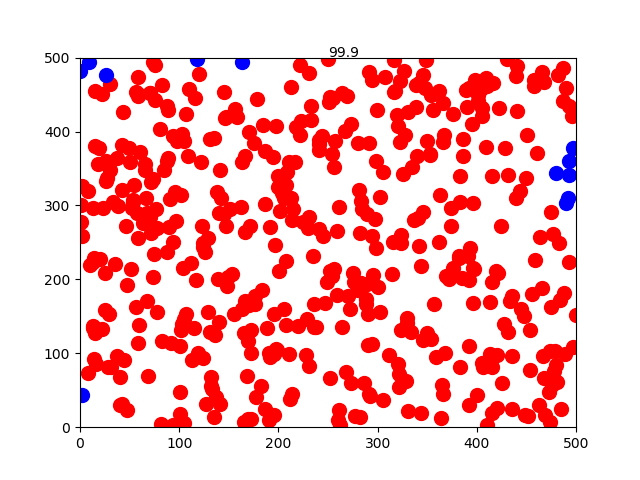

In [377]:
'''making the animation'''
%matplotlib notebook
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, N), ylim=(0, N))
infected, = ax.plot([], [],'ro', ls='',markersize=10)
susceptible, = ax.plot([], [],'bo', ls='',markersize=10)
title = ax.text(N/2,N+1,'blah')

# initialization function: plot the background of each frame
def init():
    infected.set_data([],[])
    susceptible.set_data([],[])
    return infected,susceptible,

def init_custom() :
    infected.set_data([],[])
    susceptible.set_data([],[])
    j = 0
    '''uncomment the following if links needs to be displayed but this takes time'''
#     for counter in range(len(edge_list)):
#         im = plt.plot([coords[edge_list[j][0]][0],coords[edge_list[j][1]][0]],\
#                  [coords[edge_list[j][0]][1],coords[edge_list[j][1]][1]],'black',alpha=0.1)
#         j = j + 1
    
    return infected,susceptible

# animation function.  This is called sequentially
def animate(i):
    title.set_text(t[i])
    x = []
    y = []
    where = np.transpose(np.where(numpy_array[:,i]==2))
    for k in range(len(where)) : #nodes
        x.append(coords[where[k][0]][0])
        y.append(coords[where[k][0]][1])
    infected.set_data(x, y)
    
    x = []
    y = []
    where = []
    where = np.transpose(np.where(numpy_array[:,i]==1))
    for k in range(len(where)) : #nodes
        x.append(coords[where[k][0]][0])
        y.append(coords[where[k][0]][1])
    susceptible.set_data(x, y)

    return infected,susceptible,title,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init_custom,blit=False)

# anim.save('basic_animation.mp4', fps=10, extra_args=['-vcodec', 'libx264'])
anim.save('basic_animation.mp4', fps=10)

# plt.show()